# Apache Spark Experiments - Wikipedia Top Contributors

## Spark Application


The application analyses the last revision of every Wikipedia page and outputs the top 10 contributors.
Relevant lines follow:

```python
schema = StructType([
    # ... So Spark doesn't need to scan all the data to infer its schema
])

wikiData = sqlCtx.jsonFile("hdfs://namenode:8020/enwiki.json",
                           schema=schema)
wikiData.registerAsTable("wikiData")
users = sqlCtx.sql("SELECT revision.contributor.username as user, "
                   "       COUNT(*) AS contribs "
                   "FROM wikiData "
                   "WHERE revision.contributor.username <> '' "
                   "GROUP BY revision.contributor.username "
                   "ORDER BY contribs DESC LIMIT 10").collect()

for user in users:
    print("%s: %d" % user)
```

Output for all the Wikipedia dump from enwiki-20150304-pages-articles.xml.bz2 (45 GB of JSON input):

    Addbot: 426703
    RjwilmsiBot: 408537
    Xqbot: 368493
    RussBot: 274009
    Legobot: 267074
    BOTijo: 245795
    AvicBot: 229107
    Cydebot: 224454
    Yobot: 221754
    EmausBot: 177984

## Weak-scaling Experiment

The amount of data is fixed: 1 GB per node, less than the available memory. The nodes are virtual machines from Nuvem USP.

In [10]:
# ipython notebook configuration
# Show graph in this notebook instead of opening a window
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

# Make graphs more readable
matplotlib.rcParams.update({'font.size': 16, 'font.family': 'serif', 'lines.linewidth': 2})

# Weak Scaling

In [2]:
# Parse and sort Spark applications' log by execution start time

def parse_weak():
    from sparklogstats import LogParser
    parser = LogParser()

    import glob
    apps = []
    for log in glob.glob('weak_scaling_data/app-*'):
        parser.parse_file(log)
        app = parser.app
        app.start /= 1000  # msec to sec
        app.end /= 1000
        app.workers = len(app.workers)
        apps.append(parser.app)
    apps.sort(key=lambda x: x.start)
    apps = tuple(apps)  # immutable to prevent mistakes
    worker_amounts = tuple(sorted(set(app.workers for app in apps)))
    
    return (apps, worker_amounts)

In [ ]:
apps, worker_amounts = parse_weak()

## Scatter Plot
Scatter plot with all durations in *y* and start time in *x*. Uses different colors for each worker amount.

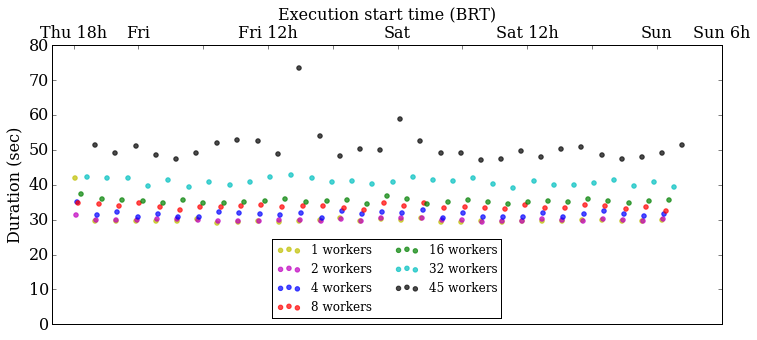

In [14]:
# Moving x axis to the top
_, ax = plt.subplots(figsize=(12,5))
ax.xaxis.set_label_position('top')
ax.xaxis.tick_top()

worker_amounts = tuple(sorted(set((len(app.workers) for app in apps))))
colors = ('y', 'm', 'b', 'r', 'g', 'c', 'k')
min_tstamp = apps[0].start
for worker_amount, color in zip(worker_amounts, colors):
    w_apps = [app for app in apps if len(app.workers) == worker_amount]
    xs = [app.start for app in w_apps]
    ys = [app.duration for app in w_apps]
    label = '{:d} workers'.format(worker_amount)
    plt.scatter(xs, ys, color=color, alpha=0.7, label=label)

plt.legend(loc='lower center', ncol=2, fontsize=12)
plt.ylim(0, 80)
plt.ylabel('Duration (sec)')

# Date and time in x axis
plt.xlabel('Execution start time (BRT)')
h6 = 6 * 60 * 60  # 6 hours in seconds
tstamps = range(1431637200, 1431658800 + 9*h6 + 1, h6)
ts_labels = ['Thu 18h', 'Fri', '', 'Fri 12h', '', 'Sat', '', 'Sat 12h', '', 'Sun', 'Sun 6h']
plt.xticks(tstamps, ts_labels)
plt.xlim(1431637200 - 2 * 3600, 1431658800 + 9*h6)

plt.show()

## Execution Time Prediction

Is it possible to predict the execution time of the whole application (45 GB of data and 45 VMs) using only a few machines?

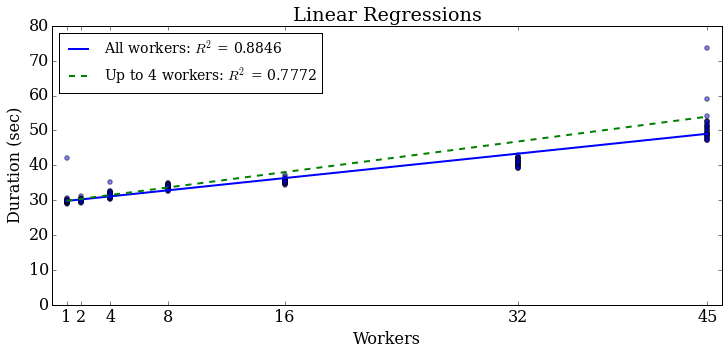

In [72]:
# Linear regression on amount of workers and execution time
plt.subplots(figsize=(12,5))

xs = [len(app.workers) for app in apps]
ys = [app.duration for app in apps]
plt.scatter(xs, ys, alpha=0.5)

# coefficient of determination calculation as in Jain's book,
y_mean = sum(ys)/len(ys)
sst = sum(map(lambda y: (y - y_mean)**2, ys))
def calc_r2(slope, intercept):
    sse = 0
    for app in apps:
        x = len(app.workers)
        y = app.duration
        y_ = intercept + slope*x
        sse += (y - y_)**2
    return (sst - sse)/sst
    
def plot_linregress(selected_workers, label, marker):
    _apps = [app for app in apps if len(app.workers) in selected_workers]
    _xs = [len(app.workers) for app in _apps]
    _ys = [app.duration for app in _apps]
    slope, intercept, r_value, p_value, std_err = stats.linregress(_xs, _ys)
    r2 = calc_r2(slope, intercept)
    label += r': $R^{2}$' + ' = {:.4f}'.format(r2)
    def f(x): return intercept + slope*x
    plt.plot([1, 45], [f(1), f(45)], marker, label=label, linewidth=2)

# Linear regressions using different amount of workers
plot_linregress(worker_amounts, label='All workers', marker='-')
plot_linregress((1, 2, 4), label='Up to 4 workers', marker='--')
plt.legend(loc='upper left', fontsize=14)

plt.xlim(0, 46)
plt.xticks(worker_amounts)
plt.ylim(0, 80)
plt.xlabel('Workers')
plt.ylabel('Duration (sec)')
plt.title('Linear Regressions')
plt.show()

In the figure above, we can notice that the experiments with up to 4 workers result in a regression with an $R^{2}$ coeffcient close to the one obtained with all the experiments. Thus, we can have a reasonable prediction by using 10x less VMs.

## Cloud Performance Variability

Is there a correlation between the performance of two consecutive experiments?

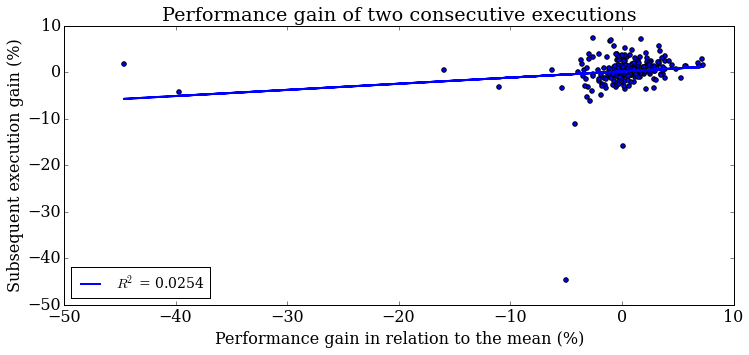

In [6]:
plt.subplots(figsize=(12,5))

# Duration means by worker amount
means = {}
for w in worker_amounts:
    means[w] = np.mean([a.duration for a in apps if len(a.workers) == w])
    
# Percentage of performance gain in relation to the mean
def calc_perf_gain(app):
    worker_amount = len(app.workers)
    mean = means[worker_amount]
    return (mean - app.duration)/mean * 100

gains = [calc_perf_gain(app) for app in apps]
xs = gains[:-1]
ys = gains[1:]  # ys[i] is the execution that follows xs[i]
plt.scatter(xs, ys)

# Linear regression
slope, intercept, r_value, p_value, std_err = stats.linregress(xs, ys)
def f(x): return intercept + slope*x
label = r'$R^{2}$' + ' = {:.4f}'.format(r_value**2)
plt.plot(xs, list(map(f, xs)), linewidth=2, label=label)

plt.xlabel('Performance gain in relation to the mean (%)')
plt.ylabel('Subsequent execution gain (%)')
plt.title('Performance gain of two consecutive executions')
plt.legend(loc='lower left', fontsize=14)
plt.show()

No correlation has been observed. However, several papers detail the performance variability of Amazon EC2. Running a benchmark right before the application execution may improve the prediction (more experiments should be done)

## Next Steps
* Strong scaling experiments
 * Nuvem USP
 * Amazon EC2
* Predict the minimum amount of VMs given an application deadline
* Analyze other types of applications
* Find common behaviors to improve the model

# Strong Scaling

In [3]:
# Parse and sort Spark applications' log by execution start time
from sparklogstats import LogParser
parser = LogParser()

import glob
apps = []
for log in glob.glob('strong_scaling_data/app-*'):
    parser.parse_file(log)
    app = parser.app
    app.start /= 1000  # msec to sec
    app.end /= 1000
    app.workers = len(app.workers)
    # Removing outlier workers = 8 and duration > 200s
    if not (app.workers == 8 and app.duration > 200):
        apps.append(parser.app)
apps.sort(key=lambda x: x.start)
apps = tuple(apps)  # immutable to prevent mistakes
worker_amounts = tuple(sorted(set(app.workers for app in apps)))

## Scatter Plot

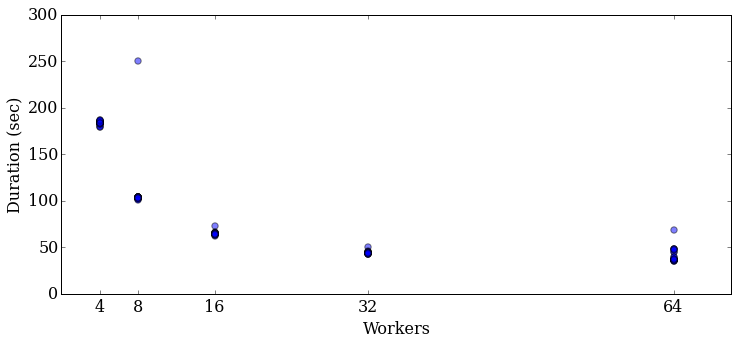

In [97]:
plt.subplots(figsize=(12,5))

xs = [app.workers for app in apps]
ys = [app.duration for app in apps]
plt.scatter(xs, ys, alpha=0.5, s=40)

plt.xticks(worker_amounts)
plt.xlabel('Workers')
plt.ylabel('Duration (sec)')
plt.show()

## Curvilinear Regression

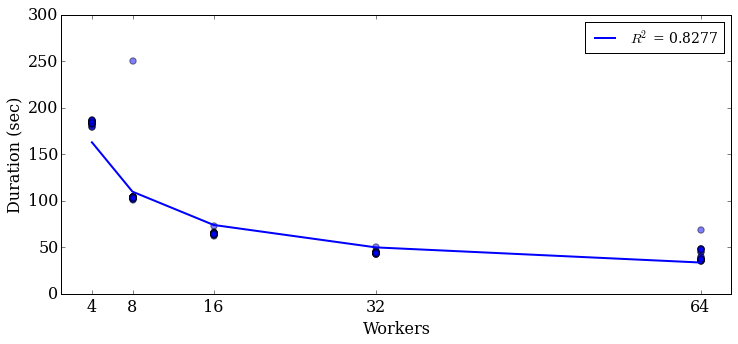

In [101]:
plt.subplots(figsize=(12,5))

# coefficient of determination calculation as in Jain's book,
y_mean = sum(ys)/len(ys)
sst = sum(map(lambda y: (y - y_mean)**2, ys))
def calc_r2(slope, intercept):
    sse = 0
    for app in apps:
        x = app.workers
        y = app.duration
        y_ = 2**intercept * x**slope
        sse += (y - y_)**2
    return (sst - sse)/sst

xs_log, ys_log = np.log2(xs), np.log2(ys)

plt.scatter(xs, ys, alpha=0.5, s=40)
plt.xticks(worker_amounts)
plt.xlabel('Workers')
plt.ylabel('Duration (sec)')

slope, intercept, r_value, p_value, std_err = stats.linregress(xs_log, ys_log)
my_r_value = calc_r2(slope, intercept)
label = r'$R^{2}$' + ' = {:.4f}'.format(my_r_value**2)
def f(x): return 2**intercept * x**slope
xs_reg = xs
ys_reg = [f(x) for x in xs_reg]
plt.plot(xs_reg, ys_reg, label=label, linewidth=2)
plt.legend(fontsize=14)
plt.show()

## Map tasks

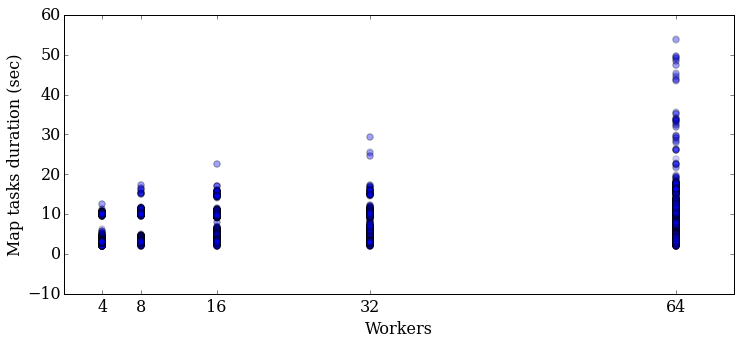

In [122]:
# Map task durations
plt.subplots(figsize=(12,5))

for app in apps:
    ys = [t.duration/1000 for t in app.stages[0].tasks]
    xs = [app.workers] * len(ys)
    plt.scatter(xs, ys, alpha=0.2, s=40)

plt.xticks(worker_amounts)
plt.xlabel('Workers')
plt.ylabel('Map tasks duration (sec)')
plt.show()

## Normality test

In [118]:
import matplotlib.mlab as mlab

for workers in worker_amounts:
    _apps = (a for a in apps if a.workers == workers)
    durations = [t.duration/1000 for a in _apps for t in a.stages[0].tasks]
    _, p_value = stats.normaltest(durations)
    if p_value < 0.05:
        result = 'not a normal distribution'
    else:
        result = 'normal distribution'
    print('{:02d}-worker p-value = {}, {}'.format(workers, p_value, result))

04-worker p-value = 0.0, not a normal distribution
08-worker p-value = 0.0, not a normal distribution
16-worker p-value = 0.0, not a normal distribution
32-worker p-value = 0.0, not a normal distribution
64-worker p-value = 0.0, not a normal distribution


## Histograms

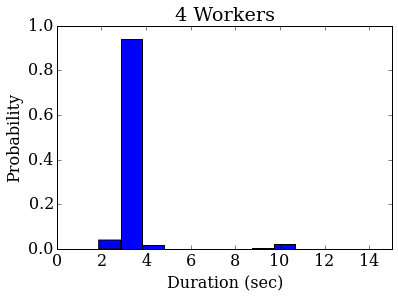

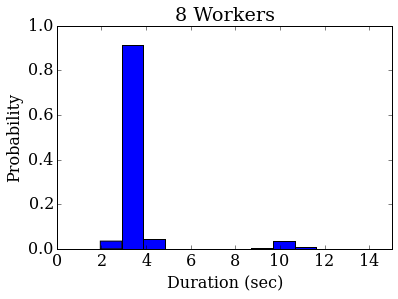

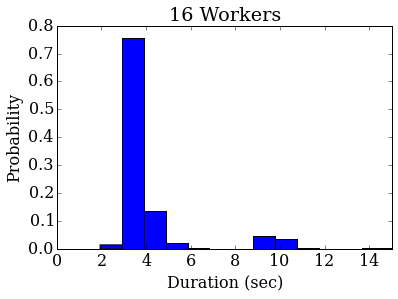

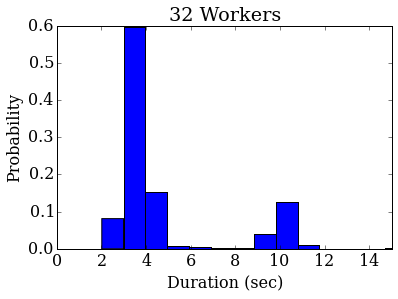

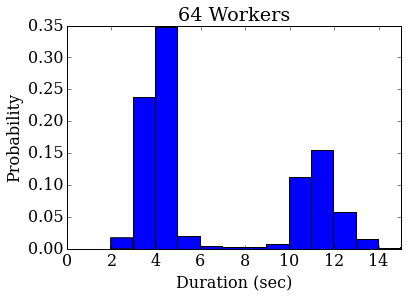

In [70]:
for workers in worker_amounts:
    _apps = (a for a in apps if a.workers == workers)
    durations = np.array([t.duration/1000 for a in _apps for t in a.stages[0].tasks])
    bins = max(durations) - min(durations) + 1
    plt.hist(durations, bins, normed=True)
    plt.ylabel('Probability')
    plt.xlabel('Duration (sec)')
    plt.xlim(0, 15)
    plt.title('{:d} Workers'.format(workers))
    plt.show()

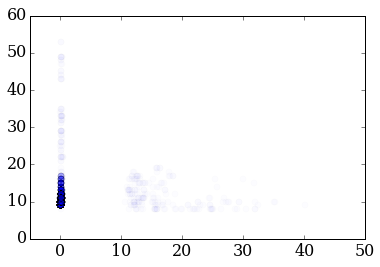

In [14]:
for app in apps:
    map_tasks = [t for t in app.stages[0].tasks if t.duration >= 8000]
    ys = np.array([task.duration for task in map_tasks])
    ys /= 1000
    xs = np.array([task.start for task in map_tasks])
    xs = (xs - min(xs))/1000
    plt.scatter(xs, ys, alpha=0.01, s=40)
plt.xlim(xmin=-5)
plt.show()

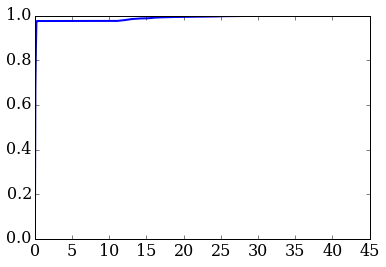

In [111]:
starts = []
for app in apps:
    workers = app.workers
    _starts = np.array([t.start for t in app.stages[0].tasks if t.duration >= 8000])
    starts.extend((_starts - min(_starts))/1000)
starts.sort()    

xs = [starts[0]]
ys = [1]
for start in starts[1:]:
    if start == xs[-1]:
        ys[-1] += 1
    else:
        xs.append(start)
        ys.append(1)

ys = np.array(ys)
ys = ys/ys.sum()

plt.plot(xs, ys.cumsum(), linewidth=2)
plt.ylim(ymax=1)
plt.show()

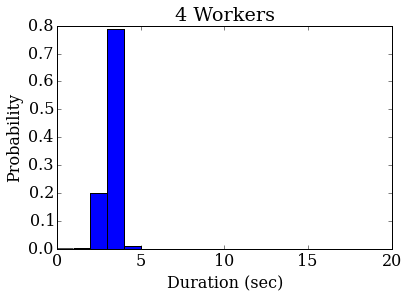

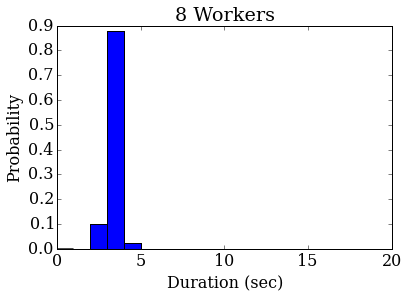

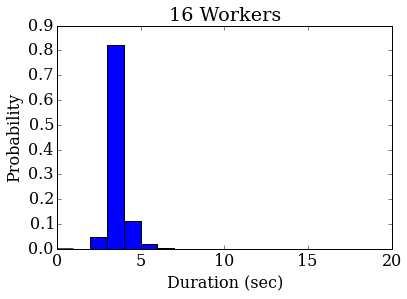

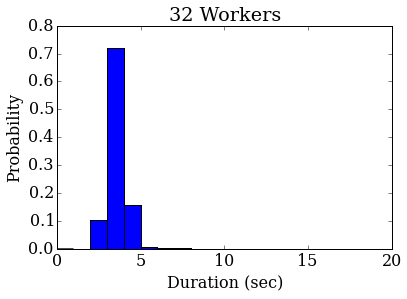

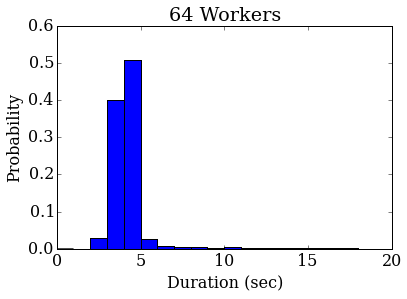

In [160]:
for workers in worker_amounts:
    durations = []
    for app in (a for a in apps if a.workers == workers):
        durations.extend([t.duration for t in app.stages[0].tasks[2*workers:]])
    durations = np.array(durations) / 1000
    xlim = (0, 20)  # by visualization
    bins = xlim[1]
    plt.hist(durations, bins, normed=True, range=xlim)
    plt.ylabel('Probability')
    plt.xlabel('Duration (sec)')
    plt.xlim(xlim)
    plt.title('{:d} Workers'.format(workers))
    plt.show()

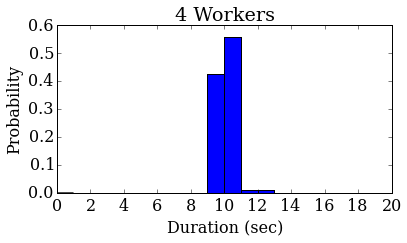

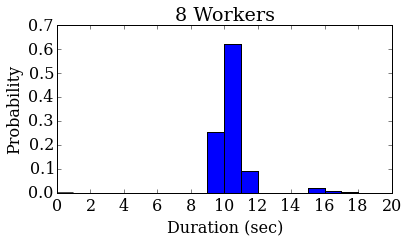

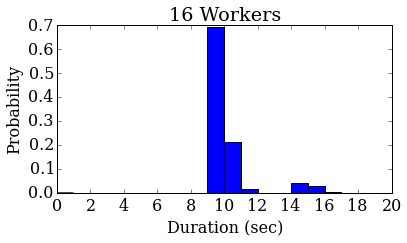

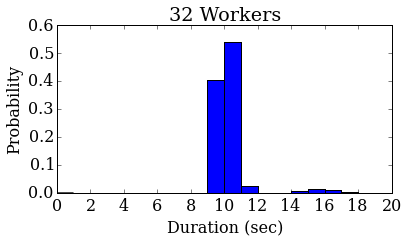

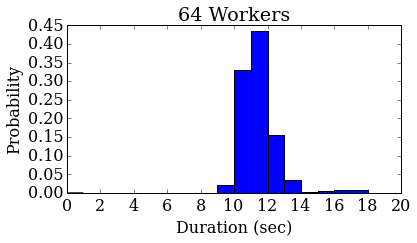

In [113]:
for workers in worker_amounts:
    plt.subplots(figsize=(6,3))
    durations = []
    for app in (a for a in apps if a.workers == workers):
        durations.extend([t.duration for t in app.stages[0].tasks[:2*workers]])
    durations = np.array(durations) / 1000
    xlim = (0, 20)  # by visualization
    bins = xlim[1]
    #bins = max(durations) - min(durations) + 1
    
    plt.ylabel('Probability')
    plt.xlabel('Duration (sec)')
    plt.xlim(xlim)
    plt.title('{:d} Workers'.format(workers))
    plt.xticks(range(0, 21, 2))
    plt.hist(durations, bins, normed=True, range=xlim)
    plt.show()

In [4]:
apps_weak, worker_amounts_weak = parse_weak()

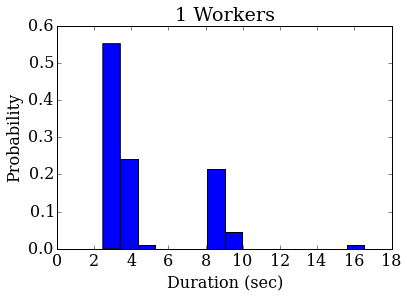

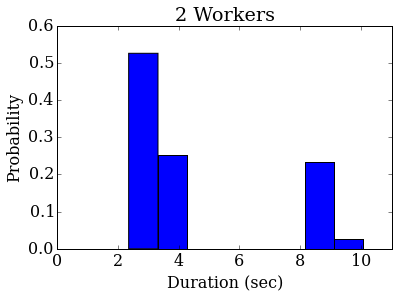

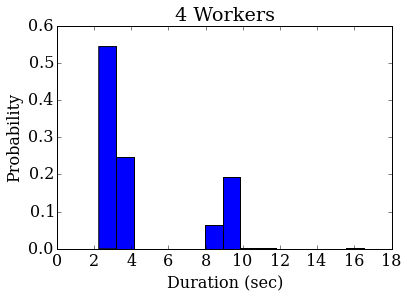

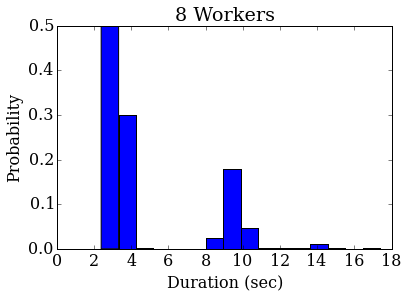

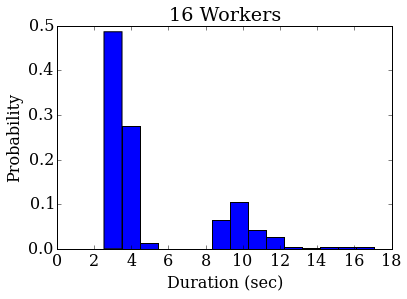

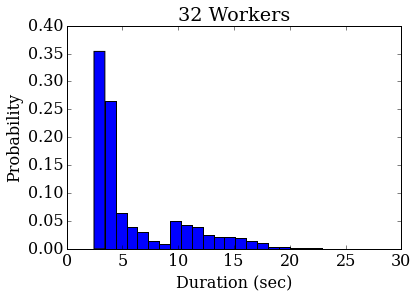

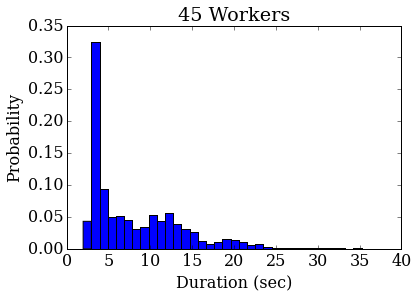

In [114]:
for workers in worker_amounts_weak:
    _apps = (a for a in apps_weak if a.workers == workers)
    durations = np.array([t.duration/1000 for a in _apps for t in a.stages[0].tasks])
    bins = max(durations) - min(durations) + 1
    plt.hist(durations, bins, normed=True)
    plt.ylabel('Probability')
    plt.xlabel('Duration (sec)')
    plt.xlim(xmin=0)
    plt.title('{:d} Workers'.format(workers))
    plt.show()

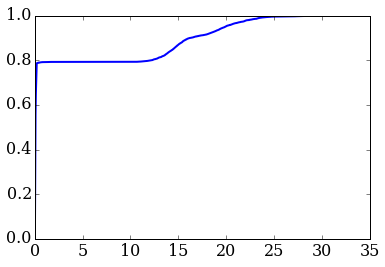

In [106]:
starts = []
for app in apps_weak:
    workers = app.workers
    _starts = np.array([t.start for t in app.stages[0].tasks if t.duration >= 8000])
    starts.extend((_starts - min(_starts))/1000)
starts.sort()    

xs = [starts[0]]
ys = [1]
for start in starts[1:]:
    if start == xs[-1]:
        ys[-1] += 1
    else:
        xs.append(start)
        ys.append(1)

ys = np.array(ys)
ys = ys/ys.sum()

plt.plot(xs, ys.cumsum(), linewidth=2)
plt.ylim(ymax=1)
plt.show()

## Prediction

In [148]:
?plt.scatter

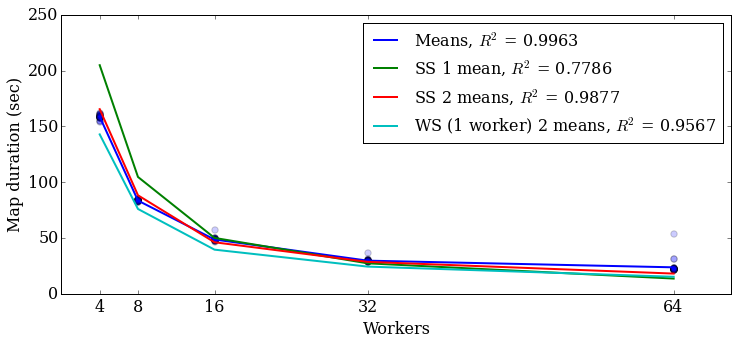

In [17]:
# Map task durations
plt.subplots(figsize=(12,5))

xs, ys = [], []
for app in apps:
    ys.append(app.stages[0].tasks_duration()/1000)
    xs.append(app.workers)
plt.scatter(xs, ys, alpha=0.2, s=40)

# coefficient of determination calculation as in Jain's book,
y_mean = sum(ys)/len(ys)
sst = sum(map(lambda y: (y - y_mean)**2, ys))
n_tasks = len(apps[0].stages[0].tasks)  # TODO check
def calc_r2(predictor):
    sse = 0
    for x, y in zip(xs, ys):
        y_ = predictor(x)
        sse += (y - y_)**2
    return (sst - sse)/sst

# Means
means = []
for workers in worker_amounts:
    _ys = []
    _apps = (a for a in apps if a.workers == workers)
    _ys = [app.stages[0].tasks_duration()/1000 for app in _apps]
    means.append(np.mean(_ys))
def predictor(x): return means[worker_amounts.index(x)]
r2 = calc_r2(predictor)
label = 'Means, ' + r'$R^{2}$' + ' = {:.4f}'.format(r2)
plt.plot(worker_amounts, means, label=label)

def mean_predictor(workers, tasks, mean):
    return int(tasks/2/workers + 0.5) * mean

def two_mean_predictor(workers, tasks, low, high):
    duration = high
    tasks -= 2*workers
    duration += low * int(tasks/2/workers + 0.5)
    return duration

task_durations = [t.end - t.start for a in apps for t in a.stages[0].tasks]
mean = np.mean(task_durations) / 1000
def predictor(x): return mean_predictor(x, n_tasks, mean)
_ys = [predictor(x) for x in worker_amounts]
r2 = calc_r2(predictor)
label = 'SS 1 mean, ' + r'$R^{2}$' + ' = {:.4f}'.format(r2)
plt.plot(worker_amounts, _ys, label=label)

def get_two_means_predictions(apps):
    slow_tasks, fast_tasks = [], []
    for app in apps:
        slow_tasks.extend([t.duration for t in app.stages[0].tasks[:2*app.workers]])
        fast_tasks.extend([t.duration for t in app.stages[0].tasks[2*app.workers:]])
    slow_mean = np.mean(slow_tasks) / 1000
    fast_mean = np.mean(fast_tasks) / 1000
    
    def predictor(x):
        return two_mean_predictor(x, n_tasks, fast_mean, slow_mean)
    _ys = [predictor(x) for x in worker_amounts]
    r2 = calc_r2(predictor)
    
    return _ys, r2

# Using the same experiment means
_ys, r2 = get_two_means_predictions(apps)
label = 'SS 2 means, ' + r'$R^{2}$' + ' = {:.4f}'.format(r2)
plt.plot(worker_amounts, _ys, label=label)

_apps = (a for a in apps_weak if a.workers == 1)
_ys, r2 = get_two_means_predictions(_apps)
label = 'WS (1 worker) 2 means, ' + r'$R^{2}$' + ' = {:.4f}'.format(r2)
plt.plot(worker_amounts, _ys, label=label)

plt.xticks(worker_amounts)
plt.xlabel('Workers')
plt.ylabel('Map duration (sec)')
plt.legend(fontsize=16)
plt.show()